## Introduction
In this notebook we will create a custom DataSet which will load and return an X-Ray image together with the location of the heart

## Imports:

* Path for easy path handling
* torch for dataset creation
* numpy for loading the images
* pandas for loading the csv file containing the labels
* imgaug to set a random seed for augmentations
* BoundingBox from imgaug to automatically handle the coordinates when augmenting the image



In [25]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
# import imgaug
# from imgaug.augmentables.bbs import BoundingBox

# import torchvision

from torchvision.tv_tensors import BoundingBoxes
from torchvision.transforms import v2

## DataSet Creation
Now we define the torch dataset!
We need to define a __ len __ function which returns the length of the dataset and a __ getitem __ function which returns the image and corresponding bounding box.

Additionally we apply data augmentation and normalization.

**Important**: Augment bounding box together with image!<br />
You can use *BoundingBox(x1, y1, x2, y2) for that*.<br />
Next you call *self.augment(image=img, bounding_boxes=bb)* which returns the augmented image and bounding boxes<br />
Finally you extract the coordinates from the augmented bbox coordinates. Note that it is a 2D array.
```python
bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
```

In [26]:
mu = 0.49
std_mg = 0.082

In [27]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        
        self.labels = pd.read_csv(path_to_labels_csv)
        
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs
        
    def  __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.patients)
        
    def __getitem__(self, idx):
        """
        Returns an image paired with bbox around the heart
        """
        patient = self.patients[idx]
        # Get data according to index
        data = self.labels[self.labels["name"]==patient]
        
        # Get entries of given patient
        # Extract coordinates
        
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # get xmax from width
        y_max = y_min + data["h"].item()  # get ymax from height
        bbox = [x_min, y_min, x_max, y_max]


        # Load file and convert to float32
        file_path = self.root_path/patient  # Create the path to the file
        img = np.load(f"{file_path}.npy").astype(np.float32)
       
        # img = torch.tensor(img)

        
        # Apply imgaug augmentations to image and bounding box
        if self.augment:
            
            bb = BoundingBoxes(
            torch.tensor([bbox]),
            format="XYXY",
            canvas_size=(224, 224)
            )


            ###################IMPORTANT###################
            # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
            # https://github.com/pytorch/pytorch/issues/5059
            # random_seed = torch.randint(0, 1000000, (1,)).item()
            # imgaug.seed(random_seed) 
            #####################################################

            # random_seed = torch.randint(0, 1000000, (1,)).item()
            # torch.manual_seed(random_seed) 

            img, aug_bbox  = self.augment(img, bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[0][2], aug_bbox[0][3]
        # Normalize the image according to the values computed in Preprocessing

        img = (img - mu) / std_mg

        img = torch.tensor(img).unsqueeze(0)
        img = torch.tensor(img)
        bbox  = torch.tensor(bbox)
        return img, bbox
        # return np.array(img), np.array(bbox)


## Validate functionality

In [28]:
# import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [29]:
# # First create the augmentation object

# seq = iaa.Sequential([
#             iaa.GammaContrast(),
#             iaa.Affine(
#                 scale=(0.8, 1.2),
#                 rotate=(-10, 10),
#                 translate_px=(-10, 10)
#             )
#         ])


In [ ]:
train_transforms = v2.Compose([
                                    # v2.ToImage(),  # Convert numpy array to tensor
                                    v2.Normalize(mean=[mu], std=[std_mg]), # (0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    v2.RandomAutocontrast(),
                                    v2.RandomAffine(degrees=(-10, 10), translate=(0, 0.05), scale=(0.8, 1.2)), # Data Augmentation
                                    v2.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = v2.Compose([ 
                                    # v2.ToImage(),  # Convert numpy array to tensor
                                    v2.Normalize(mean=[mu], std=[std_mg]),  # Use mean and std from preprocessing notebook
])



In [31]:
labels_path = "./rsna_heart_detection.csv"
patients_path = "../Data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection/train_subjects_det.npy"
train_root = "../Data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection/train/"
dataset = CardiacDataset(labels_path, patients_path, train_root, train_transforms)

In [32]:
img, bbox = dataset[0]
print(img.shape, bbox.shape)

torch.Size([1, 224, 224]) torch.Size([4])


/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_32898/2973922368.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


In [33]:
len(dataset)


400

In [34]:
img, bbox = dataset[0]
# img=img.unsqueeze(0)
# img=img.transpose(0,1)
bbox.shape

/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_32898/2973922368.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


torch.Size([4])

/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_32898/2973922368.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


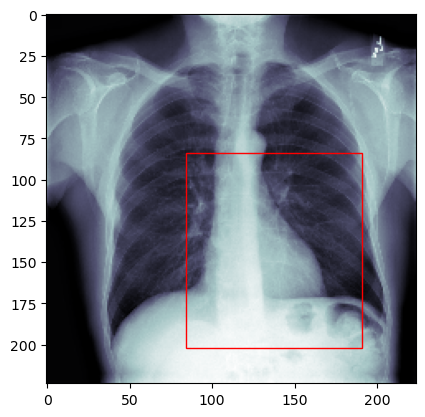

In [23]:
img, bbox = dataset[0]
# img=img.unsqueeze(0)
# img=img.squeeze(0)
# bbox = bbox.squeeze(0)
fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_32898/2973922368.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


tensor([ 73,  70, 163, 189])


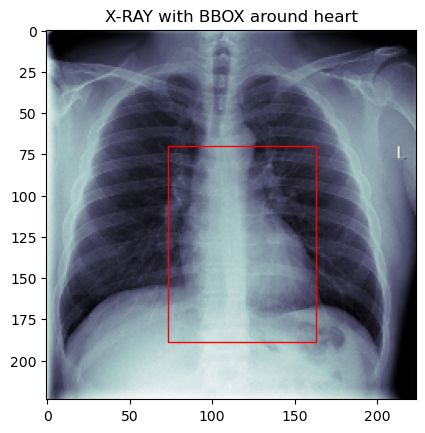

In [24]:
img, label = dataset[17]
# img=img.unsqueeze(0)
# img=img.squeeze(0)
# label = label.squeeze(0)
fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
spot1 = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='r', facecolor='none')
axis.add_patch(spot1)

axis.set_title("X-RAY with BBOX around heart")
print(label)

Awesome! Now we can move to training the heart detection network